In [1]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
Nt=1000
P=np.zeros(Nt)
T=np.zeros(Nt)
k_t=3
r=1
dt=0.01

P[0]=0.2 #Initial conditions
T[0]=0
for i in range(1,Nt):
    P[i]=P[i-1]+ P[i-1]*r*(1-P[i-1]/k_t)*dt
    T[i]=T[i-1]+dt

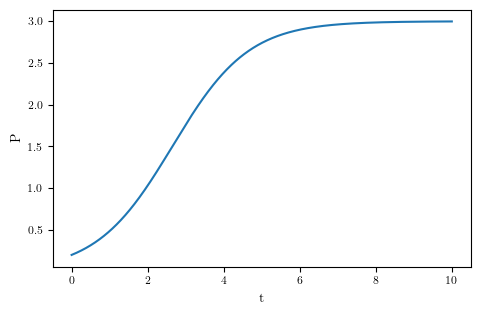

In [5]:
plt.plot(T,P)
plt.xlabel('t')
plt.ylabel('P')
plt.show()

In [6]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = X
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def net(t, w, b):
    p = DNN(t, w, b)
    return p


#@tf.function(jit_compile=True)
@tf.function()
def net_f(t, W_p, b_p, W_phi, b_phi, r):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        p=net(t, W_p, b_p)
        phi=net(p, W_phi, b_phi)
    p_t = tape1.gradient(p, t) 
    f = p_t - phi
    return f


#@tf.function()
@tf.function()
def train_step(W_p, b_p, W_phi, b_phi, X_u_train_tf, u_train_tf, X_f_train_tf, u_star_tf, opt, r):
    t_u = X_u_train_tf
    t_f = X_f_train_tf
    U_star = u_star_tf

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi, b_phi, k])
        u_nn = net(t_u, W_p, b_p) 
        phi_nn = net(U_star, W_phi, b_phi) 
        f_nn = net_f(t_f, W_p, b_p, W_phi, b_phi, r)
        loss_u = tf.reduce_mean(tf.square(u_nn - u_train_tf))
        loss_f = tf.reduce_mean(tf.square(f_nn)) 
        loss_phi = tf.reduce_mean(tf.square(phi_nn - r*U_star*(1-U_star/k_t)))

        loss =  loss_u + loss_f
    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))

    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
   
    return loss, loss_u, loss_f, loss_phi




# N_u = 100 # Number of Initial and Boundary data points
N_f = 100 # Number of residual point
N_d = 100 #Number of data

layers = [1, 50, 50, 1]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]
k = [tf.Variable(tf.ones([1,1]), dtype=tf.float32)]
W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

In [6]:
u_star = P.reshape([-1, 1])
X_star = T.reshape([-1, 1])

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)  

# Initial Condition
xx1 = T[0]
uu1 = P[0]

# Additional data
idx = np.random.choice(P.shape[0], N_d, replace=False)
xxd = T[idx]
uud = P[idx]

X_u_train = np.concatenate(([xx1],xxd)).reshape([-1,1])
u_train = np.concatenate(([uu1],uud)).reshape([-1,1])

X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))


X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
u_star_tf = tf.convert_to_tensor(u_star, dtype=tf.float32)

In [11]:
lr = 1e-3
Nmax = 10**5
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
loss_unk=[]
while n <= Nmax:
    loss_, loss_u, loss_f, loss_phi = train_step(W_p, b_p, W_phi, b_phi, X_u_train_tf, u_train_tf, X_f_train_tf,u_star_tf, optimizer, r)
    loss.append(loss_)
    loss_unk.append(loss_phi)
    if n % 10 == 0:
        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")

        print(f"Data loss is: {loss_u}")
        print(f"Physicial loss is: {loss_f}")
        print(f"Function unknown loss is: {loss_phi}")

    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 4.485562324523926
Data loss is: 4.484163761138916
Physicial loss is: 0.0013986950507387519
Function unknown loss is: 0.1072741225361824
Iteration is: 10
Total loss is: 0.2077651023864746
Data loss is: 0.15993748605251312
Physicial loss is: 0.04782761633396149
Function unknown loss is: 0.0781928077340126
Iteration is: 20
Total loss is: 0.4213801920413971
Data loss is: 0.370250403881073
Physicial loss is: 0.0511297881603241
Function unknown loss is: 0.05116414651274681
Iteration is: 30
Total loss is: 0.0626511424779892
Data loss is: 0.06055514141917229
Physicial loss is: 0.00209600361995399
Function unknown loss is: 0.029196826741099358
Iteration is: 40
Total loss is: 0.1010223999619484
Data loss is: 0.09345541894435883
Physicial loss is: 0.007566982414573431
Function unknown loss is: 0.06688333302736282
Iteration is: 50
Total loss is: 0.04352200776338577
Data loss is: 0.042114630341529846
Physicial loss is: 0.0014073760248720646
Function unknown loss is: 0

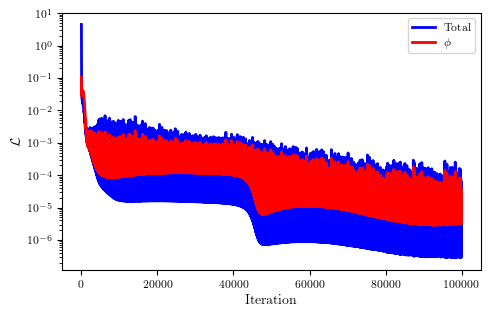

In [15]:
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_phi_list = [loss_unk[i].numpy() for i in range(0,Nmax)]

plt.semilogy(it, np.asarray(loss_list), 'b-', linewidth = 2, label = 'Total')  
plt.semilogy(it, np.asarray(loss_phi_list), 'r-', linewidth = 2, label = '$\phi$')       

plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')  
plt.legend()  
# plt.savefig('figures/loss_phi.pdf')
plt.show()

In [16]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net(x_star, w, b)
    return u_pred

## Evaluating total function
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)    
u_pred = predict(X_star_tf, W_p, b_p)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' %(error_u))                     
Error = 100* np.linalg.norm(u_star - u_pred) / np.linalg.norm(u_pred)

## Evaluating unknown function
U_star_tf = tf.convert_to_tensor(u_star, dtype=tf.float32) 
phi_pred = predict(U_star_tf, W_phi, b_phi)
phi_star=r*u_star*(1-u_star/k_t)
error_phi = np.linalg.norm(phi_star-phi_pred,2)/np.linalg.norm(phi_pred,2)
print('Error phi: %e' %(error_phi)) 
Error_phi = 100* np.linalg.norm(phi_star - phi_pred) / np.linalg.norm(phi_pred)


Error u: 3.579159e-04
Error phi: 5.031415e-03


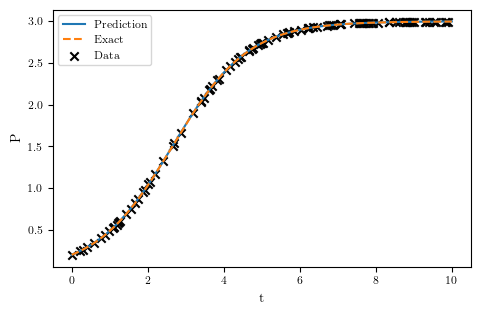

In [17]:
plt.plot(T, u_pred, label='Prediction')
plt.plot(T, P, linestyle='--', label='Exact')
plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('t')
plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

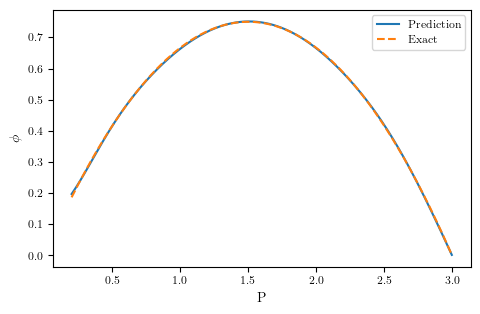

In [18]:
plt.plot(P, phi_pred, label='Prediction')
plt.plot(P, phi_star, linestyle='--', label='Exact')
# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('P')
plt.ylabel('$\phi$')
# plt.savefig('figures/phi.pdf')
plt.show()

## Symbolic Regression

In [19]:
# Create and train the PySR model
model = PySRRegressor(
    niterations=40,
    binary_operators=["+", "*"],
    # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
    unary_operators=["exp", "inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2"
)


In [20]:
# Fit phi
model.fit(u_star, np.array(phi_pred))
print(model)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 1.590e+05
Head worker occupation: 35.1%
Progress: 365 / 600 total iterations (60.833%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           7.753e-01  1.594e+01  y = 1.119
2           6.986e-02  2.407e+00  y = inv(3.5829)
4           5.481e-02  1.213e-01  y = inv(1.6681 + x₀)
5           4.099e-02  2.906e-01  y = (-0.17516 * x₀) + 0.66185
6           3.967e-02  3.274e-02  y = x₀ * exp(x₀ * -0.89199)
7           3.244e-06  9.410e+00  y = (x₀ * (-2.9992 + x₀)) * -0.33322
9           3.244e-06  1.192e-07  y = (-0.57716 * (0.57735 * (x₀ + -2.9992))) * x₀
11          3.230e-06  2.180e-03  y = (((1.1354 + (x₀ * -0.37852)) * x₀) * 0.88074) + -0.0004893...
                                  4
13          3.219e-06  1.690e-03  y = ((x₀ * -0.33321) + 0.99937) * (exp(-16.287 * inv(x₀)) + x₀...
                                  )
14          2.564e-06

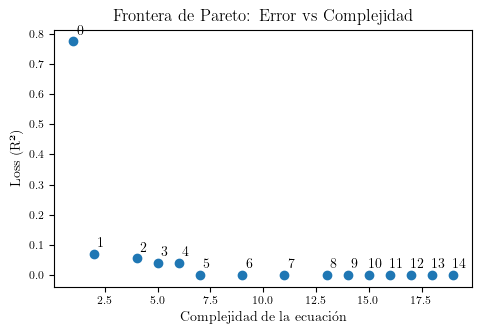

In [21]:
# Extraer las métricas de las ecuaciones
equations_df = model.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.show()

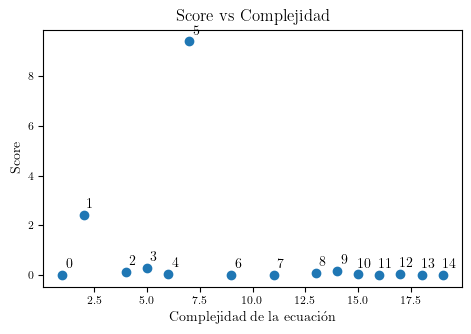

In [22]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


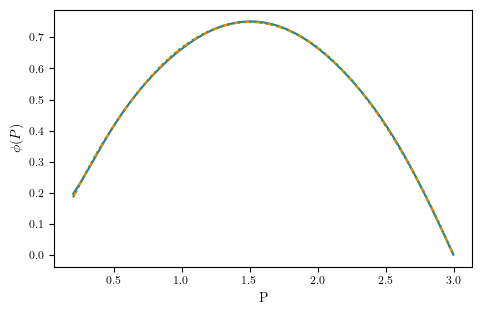

In [23]:
symb1=model.predict(u_star,5)
plt.plot(u_star, phi_pred, label='PINN prediction')
plt.plot(u_star, symb1, linestyle='--', label='Symbolic regresion')
plt.plot(u_star, phi_star, linestyle=':', label='Exact')

plt.xlabel('P')
plt.ylabel('$\phi (P)$')
plt.show()



In [24]:
model.sympy(5)

x0*(x0 - 2.9992027)*(-0.33322477)

In [38]:
# Fit dP/dt
# Create and train the PySR model
model = PySRRegressor(
    niterations=50,
    binary_operators=["+", "*"],
    # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
    unary_operators=[ "exp",  "inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2"
)

model.fit(X_star, np.array(u_pred))
print(model)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.770e+05
Head worker occupation: 41.9%. This is high, and will prevent efficient resource usage. Increase `ncycles_per_iteration` to reduce load on head worker.
Progress: 363 / 750 total iterations (48.400%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           9.410e-01  7.971e+00  y = exp(0.78197)
3           2.671e-01  1.259e+00  y = x₀ * 0.40472
5           1.593e-01  2.583e-01  y = 0.65599 + (x₀ * 0.30627)
7           1.800e-02  1.090e+00  y = x₀ * (0.73976 + (-0.044695 * x₀))
9           1.429e-02  1.151e-01  y = -0.17173 + (x₀ * (0.81764 + (x₀ * -0.051188)))
11          5.271e-03  4.988e-01  y = inv(exp(inv(-1.439) * x₀) + exp(-1.3587)) + -0.81707
12          8.459e-07  8.737e+00  y = inv(exp(-1.0989) + exp(-1.0009 * (-1.545 + x₀))) + -2.9919...
                                  e-09
13          7.168e-07  1.656e-01  y = inv(exp(-1

In [39]:
model.sympy(4)

1/(0.33376604 + 4.63841725865923*exp(-x0))

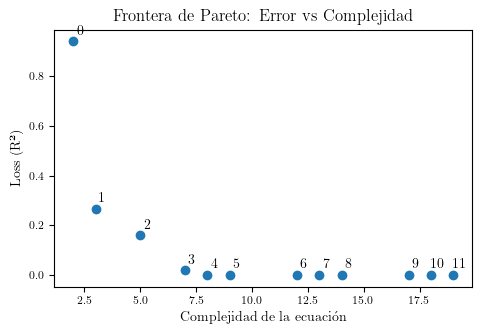

In [40]:
# Extraer las métricas de las ecuaciones
equations_df = model.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.show()

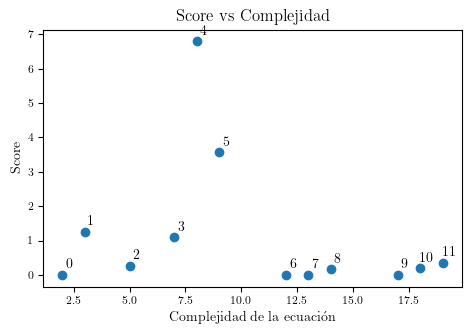

In [41]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


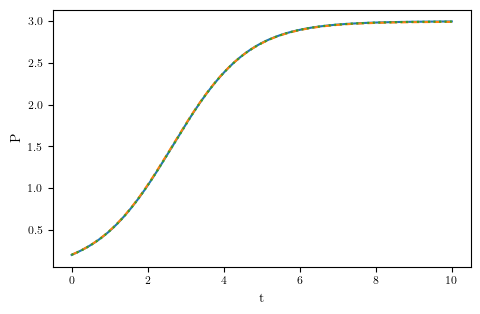

In [43]:
symb1=model.predict(X_star,4)
plt.plot(X_star, u_pred, label='PINN prediction')
plt.plot(X_star, symb1, linestyle='--', label='Symbolic regresion')
plt.plot(T, P, linestyle=':', label='Exact')

plt.xlabel('t')
plt.ylabel('P')
plt.show()

